# Solution

In [1]:
import sklearn
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

tf.enable_eager_execution()

C:\Users\CSANT\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Data Cleaning

In [2]:

def clean_data_test(data):
    data.dropna(how="all", inplace=True)
    data = data.set_index(data.iloc[0::,0], drop=True, append=False, inplace=False, verify_integrity=False)
    data.columns = data.iloc[0]
    data = data.drop("Fecha", axis=1)
    if "Fecha" in data.index: data.drop("Fecha", axis = 0, inplace=True)
    data.columns.name = "Prices"
    data.index.name = "Dates"
    return data

def clean_data(data):
    data = pd.read_excel(data_path + files_xls[16], header=2, parse_col="A:Z")
    return data

# Data Reading

In [5]:
folder = "datos/precios/"

files = os.listdir(folder)

files_xls = [f for f in files if f[-3:] == 'xls' or f[-4:] == 'xlsx']

data = pd.read_excel(folder + files_xls[0], header=2, usecols="A:Y")

iterfiles = iter(files_xls) 
next(iterfiles)

for f in iterfiles:
    data = data.append(pd.read_excel(folder + f, header=2, usecols="A:Y"),  ignore_index=True)
data = data.drop("Fecha", axis=1)

nans = sum(pd.isnull(data).sum().values)
nans_per = 1 - (len(data.index) - nans) / len(data.index)

data.dropna(how="any", inplace=True)
data.reset_index(drop=True)

data.shape
data.head()


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
1,1.073,1.000,1.000,1.00,1.00,1.000,5.000,6.000,6.000,6.000,...,5.000,1.000,1.000,5.000,12.000,16.670,11.929,5.000,1.000,1.000
2,1.073,1.073,1.000,1.00,1.00,1.073,1.303,1.303,1.303,1.303,...,1.073,1.000,1.000,1.000,1.303,2.500,2.500,1.303,1.073,1.073
3,1.073,1.000,1.000,1.00,1.00,1.000,0.100,1.000,1.000,1.000,...,1.000,0.100,0.100,1.000,1.238,1.238,1.238,1.238,1.073,1.000
4,1.000,1.000,0.990,1.00,1.00,1.073,3.000,3.000,3.000,3.500,...,1.073,1.073,3.000,2.000,18.630,22.500,9.256,3.000,1.073,1.000
5,0.990,0.990,0.989,0.99,0.99,1.073,1.263,1.263,1.263,1.263,...,1.073,1.073,1.073,1.073,1.263,1.500,1.263,1.263,1.073,0.990


In [6]:
# Calculate mean
mean_prices = data.sum(axis=1) / (len(data.columns))

# Transformations

- Log(x)
- Exp(x)

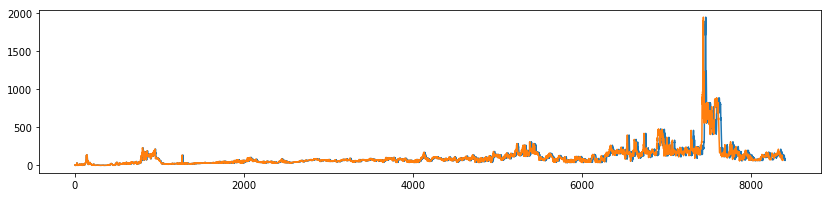

In [9]:
def exp_transf(s_data, inv_fx = None):
    data_with_transform = s_data
    if inv_fx != None:
        data_with_transform = inv_fx(data_with_transform)
    return data_with_transform

def log_transf(data, fx = None):
    
    if fx != None:      
        data_with_transform = fx(data.values)
    return data_with_transform


f = np.log
inv_f = np.exp
d = log_transf(mean_prices, f)
ds = exp_transf(d,inv_f)

In [10]:
import tensorflow as tf

class Model(object):
    
    def __init__(self, L):
        self.w = tf.contrib.eager.Variable([0.0] * (L+1))
        self.errs = []
    def __call__(self, x):
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        y_pred = tf.reduce_sum(tf.multiply(self.w, x))
        return y_pred
                             
    def fit(self, mu, x, y_desired):
        y_pred = self(x)
        e = y_desired - y_pred
        self.errs.append(e)
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        self.w.assign_add(tf.scalar_mul(2 * mu * e, x))
        

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class GradientDescent(object):
   
    def __init__(self, eta=0.01, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter
        
    def fit_Gradient(self, X, y_desired):
        self.w_ = np.zeros(2)
        self.errors_ = []
        
        for i in range(self.n_iter):
            errors = 0
            for j in range(X.shape[0]):
                self.w_[1:] += self.eta*X[j]*(y[j] - self.w_[0] - self.w_[1]*X[j])
                self.w_[0] += self.eta*(y[j] - self.w_[0] - self.w_[1]*X[j])
                errors += 0.5*(y[j] - self.w_[0] - self.w_[1]*X[j])**2
            self.errors_.append(errors)
        return self
    
    def predict(self, X):
        return self.w_[0] + self.w_[1]*X


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

SSE: tf.Tensor(2.7817962, shape=(), dtype=float32)
MSE: tf.Tensor(0.000925534, shape=(), dtype=float32)
RMSE:0.03042259


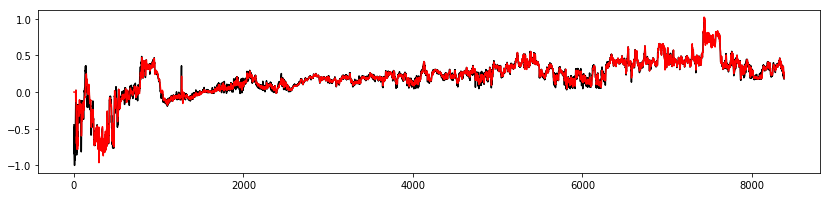

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics 

L = 20

model = Model(L)
gda = GradientDescent(eta=0.1, n_iter=100)

y_pred = np.empty(len(d))
y_pred[:] = 0

for t in range(L, len(d)):
    x = d[t-L:t]
    y_pred[t] = model(x)
    model.fit(mu=0.05, x=x, y_desired=d[t])
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
    

SSE = sum(model.errs)
MSE = sum(model.errs)**2 / len(model.errs)
RMSE= np.sqrt(MSE)

print("SSE: " + str(SSE))
print("MSE: " + str(MSE))
print("RMSE:" + str(RMSE))

plt.figure(figsize=(14,3))
plt.plot(d, color='black');
plt.plot(y_pred, color = 'red');


# Forecast

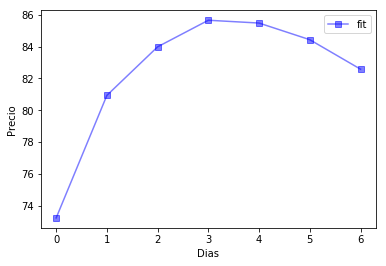

In [13]:
nd = d[-1 * L:]

n_of_pred = 7
for i in range(n_of_pred):
    nd.append(model(nd[-1 * L:]))
    
seven_pred = exp_transf(nd[-1*n_of_pred:], a, b, inv_f)
plt.figure()
plt.plot(seven_pred, marker='s',c='b',alpha=0.5,label='fit')
plt.xlabel('Dias')
plt.ylabel('Precio')
plt.legend()

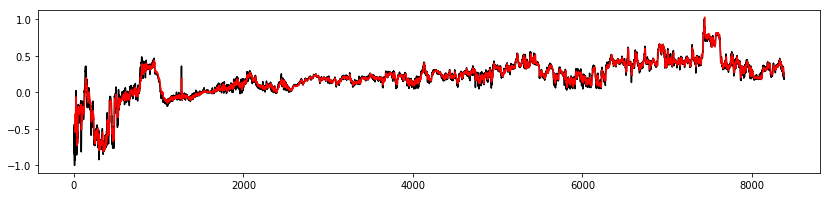

In [29]:
mu = 0.01

L = 11

w = np.array(0.1 * np.random.standard_normal(L+1)).reshape(L+1, 1)

y_pred = np.zeros(len(d))
y_pred[0:L] = np.nan
for t in range(L, len(d)):
    x = np.array([1] + d[t-L:t])
    x = x.reshape(len(x), 1)
    p = w.T @ x                  
    y_pred[t] = p
    
    e = d[t] - p
    w = w + 2 * mu * e * x

plt.figure(figsize=(14,3))
plt.plot(d, color='black');
plt.plot(y_pred, color = 'red');